In [ ]:
# default_exp training

# Training Data

In [ ]:
#export
from random import randint
import random
from pathlib import Path
from PIL import Image, ImageDraw
import pandas as pd
from collections import namedtuple
from fastai.vision.all import *
import matplotlib.pyplot as plt
import numpy as np
import PIL
import chessocr
import re
from itertools import product
from IPython.core.pylabtools import print_figure

In [ ]:
#export
boards_url = Path(chessocr.__file__).parent.parent/"img/boards"
pieces_url = Path(chessocr.__file__).parent.parent/"img/pieces"
m = re.compile('^[0-9]+$')
piece_dirs = sorted([_ for _ in pieces_url.iterdir() if m.match(_.name)], key=lambda i: int(i.name))

## Boards and Board

In [ ]:
#export
class Board:
    """ 
        Represents a rendered board with particular dark and light colors.
        There are no pieces on the board.
    """
    def __init__(self, img): self.img = img
    def _repr_png_(self): return self.img.resize((100, 100))._repr_png_()

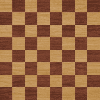

In [ ]:
img=Image.open(get_image_files(boards_url)[0])
Board(img)

In [ ]:
#export
class Boards:
    """ 
        Container object holding `Board` objects.
    """
    def __init__(self, url):
        self.boards = [Board(Image.open(_)) for _ in get_image_files(url)]
        self._png_data = None
    def __len__(self): return len(self.boards)
    def __getitem__(self, key): return self.boards[key]
    def __iter__(self): return self.boards.__iter__()
    def _repr_png_(self): 
        if not self._png_data:
            self._png_data = self._figure_data('png')
        return self._png_data

    def _figure_data(self, format):
        rows = len(self) // 9 + 1
        fig, axs = plt.subplots(rows, 7, figsize=(14, 8))
        for i in range(len(self)):
            ax=axs.ravel()[i]
            ax.imshow(self[i].img)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_title(f"{i}")

        data = print_figure(fig)
        plt.close(fig)
        return data

In [ ]:
boards = Boards(boards_url)

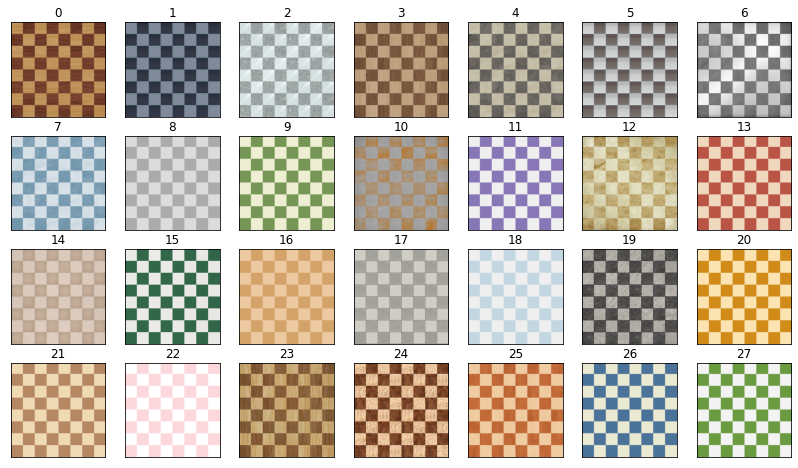

In [ ]:
boards

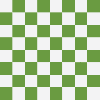

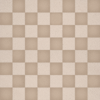

In [ ]:
boards[27]; boards[14]

## PieceSet and PieceSets

In [ ]:
#export
class Piece:
    """ non data descriptor """
    def __set_name__(self, owner, name): self.name=name
    def __get__(self, obj, type=None): return Image.open(obj.dir/f'{self.name[1]}_{self.name[0]}.png')

In [ ]:
class PieceSet:
    """ 
        Represents the 12 individual pieces comprising a chess set. 
        This includes a rook, knight, bishop, queen, king, and pawn for both black and white pieces.
    """
    _attrs = [f'{_[0]}{_[1]}' for _ in product('wb', 'rnbqkp')]
    wr=Piece()
    wn=Piece()
    wb=Piece()
    wq=Piece()
    wk=Piece()
    wp=Piece()
    
    br=Piece()
    bn=Piece()
    bb=Piece()
    bq=Piece()
    bk=Piece()
    bp=Piece()
    
    def __init__(self, dir): 
        self.dir = dir
        self._png_data = None
        
    def _repr_png_(self):
        if not self._png_data:
            self._png_data = self._figure_data('png')
        return self._png_data

    def _figure_data(self, format):
        fig, axs = plt.subplots(2, 6, gridspec_kw={'hspace':-0.5, 'wspace':0}, figsize=(8, 4))
        for i, attr in enumerate(list(self._attrs)):
            ax=axs.ravel()[i]
            ax.imshow(getattr(self, attr))
            ax.set_xticks([])
            ax.set_yticks([])
    
        fig.suptitle(self.dir.as_posix())
        data = print_figure(fig)
        plt.close(fig)
        return data

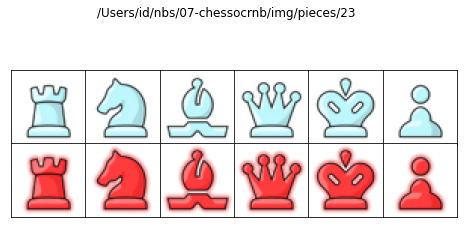

In [ ]:
idx = random.randint(0, len(piece_dirs)-1)
PieceSet(piece_dirs[idx])

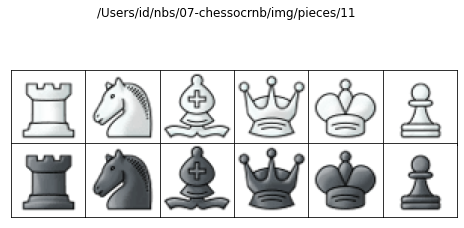

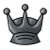

In [ ]:
idx = random.randint(0, len(piece_dirs)-1)
PieceSet(piece_dirs[idx])
PieceSet(piece_dirs[idx]).bq

In [ ]:
#export
class PieceSets:
    def __init__(self, dirs): self.sets = [PieceSet(_) for _ in dirs]
    def __getitem__(self, key): return self.sets[key]

In [ ]:
piece_sets=PieceSets(piece_dirs)

In [ ]:
#export
class GameBoard:
    """
        Represents a combination of a Board, PieceSet, and optionally a FEN to create the position.
        If no fen is provided, the GameBoard will be in the starting position
    """
    def __init__(self, board, piece_set):
        self.board = board
        self.piece_set = piece_set

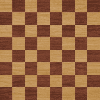

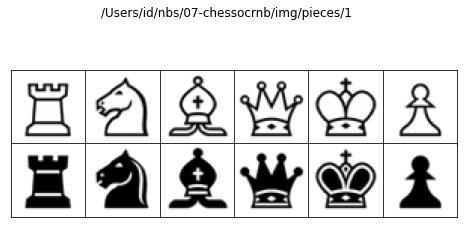

In [ ]:
boards[0]; piece_sets[0]

In [ ]:
gb = GameBoard(boards[0], piece_sets[0])

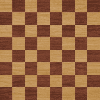

In [ ]:
gb.board

# Old Stuff

In [ ]:
wbs =  get_image_files(Path("/Users/id/.fastai/data/websites/"))
bss = get_image_files(Path("/Users/id/.fastai/data/kaggle-chess/"))

def path(x): return '/'.join(x.parts[-2:])

df0 = pd.Series(bss, name="board")
df0 = df0.apply(path)

df1 = pd.Series(wbs, name="website")
df1 = df1.repeat(len(df0)//len(df1)+1)[:len(df0)]
df1 = df1.reset_index(drop=True)

np.random.seed(123)
df1=df1.sample(frac=1).reset_index(drop=True)
df1 = df1.apply(path)
df = pd.concat([df0, df1], axis=1, ignore_index=False)

def make_sample():
    w_width = 1024
    w_height = 768
    b_width=400
    b_height=400
    x = randint(50, w_width - b_width - 50)
    y = randint(50, w_height - b_height - 50)
    dx = randint(20, 100)
    dy = randint(20, 100)
    return (x, y, dx, dy)

In [ ]:
import pandas as pd
from pathlib import Path
from PIL import Image, ImageDraw
from random import randint

In [ ]:
df = pd.read_csv("annotations.csv")
web_url = Path("/Users/id/.fastai/data/websites/")
board_url = Path("/Users/id/.fastai/data/kaggle-chess/")
gen_url = Path("/Users/id/.fastai/data/chess_screenshots2/")

def make_image(board, website, x, y, dx, dy):
    b = Image.open(board_url/board)
    s = Image.open(web_url/website)
    s.paste(b, (x, y))
    c = s.crop((x-dx, y-dy, x+400+dx, y+400+dy))
    return c

def save_image(img, i): img.save(gen_url / f'{i:06d}.png')
def PILrect(board, website, x, y, dx, dy): return ((dx, dy), (400+dx, 400+dy))

# [save_image(make_image(*_[1]), _[0]) for _ in df.iterrows()]

FileNotFoundError: [Errno 2] No such file or directory: 'annotations.csv'